Before you turn in your homework, make sure everything runs as expected.

Make sure you execute every single code cell.

**IMPORTANT:**

* **DO NOT DELETE ANY CELL** and do not change the title of the Notebook.

* Before you turn in your homework, make sure everything runs as expected: restart the kernel (in the menubar, select Kernel $\rightarrow$ Restart) and then run all cells (in the menubar, select Cell $\rightarrow$ Run All).

Fill your name below:

In [1]:
name = "Mark Yamakaitis"

# Assignment: Traffic Flow

---

Consider the flow of traffic on a one-lane highway.
How can we describe the general behavior of this system?

We can define the speed of traffic, $V$, in kilometers per hour.
We can also define a traffic density, the number of cars per unit length of highway, $\rho$, in cars per kilometer.
Finally, we can define a traffic flux, or the flow rate of cars, $F$,in cars per hour.

Now make a few assumptions about how traffic moves.

If $\rho$ approaches $0$, i.e. there are very few cars on the road, then cars will drive as fast as they can at some $V_\text{max}$.

Conversely, if cars are bumper to bumper along the road, then $\rho$ approaches a $\rho_\text{max}$ and $V$ approaches $0$.

One possible equation to describe this behavior is

$$
\begin{equation}
    V = V_\text{max} \left( 1 - \frac{\rho}{\rho_\text{max}} \right)
\end{equation}
$$

If we describe the traffic flux, $F$ as $F = \rho V$, then

$$
\begin{equation}
    F = F \left( \rho \right) = V \left( \rho \right) \rho = V_\text{max} \rho \left( 1 - \frac{\rho}{\rho_{max}} \right)
\end{equation}
$$

Unsteady traffic flow can be modeled as the non-linear convection of car density, so we apply the non-linear convection equation with $V$, the wave speed, equal to $\frac{\partial F}{\partial \rho}$:

$$
\begin{equation}
    \frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial \rho} \frac{\partial \rho}{\partial x} = 0
\end{equation}
$$

Applying the chain rule of calculus, this becomes

$$
\begin{equation}
    \frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0
\end{equation}
$$

where $F$ is defined as above.
The PDE above is written in conservation form.
(See section at the end of Notebook for more details about the conservation form.)

You will integrate the traffic flow equation (in conservation form) using the modified Euler's method (also called midpoint method or Runge-Kutta second-order method).
You will discretize the first-order spatial derivative with a backward-difference quotient:

$$
\begin{equation}
    \left. \frac{\partial F}{\partial x} \right|_i = \frac{F_i - F_{i-1}}{\Delta x} = \frac{F(\rho_i) - F(\rho_{i-1})}{\Delta x}
\end{equation}
$$

Examine a stretch of road $22$ kilometers long using the following conditions:

* $V_\text{max} = 90 \; \text{km/h}$
* $L = 25 \; \text{km}$
* $\rho_\text{max} = 100 \; \text{cars/km}$
* $nx = 101$ (number of points to discretize the road of length $L$)
* $\Delta t = 0.001 \; \text{hours}$

## Implement your solution (40 points)

---

Implement your solution in this section.
You can use as many code cells as you want.

In [2]:
#-------- Import libraries --------
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyp
from typing import Callable
from time import perf_counter

from IPython.display import display, Markdown
def printm(string):
    display(Markdown(string))

In [3]:
#-------- Write code --------
# Initial distributions
def R0A(x):
    if x >= 2 and x <= 4.2:
        return 50.0
    else:
        return 10.0
    
def R0B(x):
    if x >= 2 and x <= 4.2:
        return 50.0
    else:
        return 20.0

# Vectorize the functions to pass arrays
R0B = np.vectorize(R0B)
R0A = np.vectorize(R0A)

# class to hold road parameters with methods to calculate derivatives and integrate
class Road:
    def __init__(self, L: float, Nx: int, Vmax: float, Rmax: float, R0: Callable[[float], float]):
        """
            Parameters
            ----------
            L : road length
            Nx: Number of Discrete points
            Vmax: Maximum car velocity [km/r]
            Rmax: Maximum car density [cars/km]
            R0: Initial density as a function of x along the road
        """
        self.L = L
        self.Vmax = Vmax
        self.Rmax = Rmax
        
        self.X = np.linspace(0, L, Nx, dtype=np.float64)
        
        self.dL = self.X[1]-self.X[0]
        
        self.R = R0(self.X)
        self.VelFlux()
        
    def VelFlux(self):
        """
            calculates car velocity and flux along the road
        """
        self.V = self.Vmax * (1- self.R/self.Rmax)
        self.F = self.R * self.V
        
    def D(self):
        """
            calculates dF/dx and dR/dt
        """
        self.dF = (self.F[1:-1] - self.F[:-2]) / self.dL
        self.dR = -self.dF
        
    def updateVFR(self, dt):
        """
            updates density along the road using the current values of dR/dt and a timestep
        """
        self.R[1:-1] += self.dR * dt
        self.VelFlux()
        
    def stepR_rk2(self, dt):
        """
            calculate the road's state after dt using a runge-kutta 2nd order method
        """
        self.Rc = np.copy(self.R) # copy initial density state to a copy
        self.D() # calculate derivatives
        self.updateVFR(.5 * dt) # step the halfway through the timestep, recalculate V, F
        self.D() # calulate derivatives at the half step
        self.R = np.copy(self.Rc) # reset the density to the beginning of the step
        self.updateVFR(dt) #update R using midpoint derivatives, update V, F

def kmh_to_ms(v):
    """
        convert from km/hr to m/s
    """
    return v / 3.6

In [4]:
# Road Params
L = 25
Nx = 101
VmaxA = 90
VmaxB = 130
Rmax = 100

dt = 1e-3

In [5]:
# step a road through a number of timesteps, keep a history of previous steps
def SolveTraffic(road, dt, t_limit):
    Rhist = pd.DataFrame(columns=road.X)
    Vhist = pd.DataFrame(columns=road.X)
    t1 = perf_counter()
    for t in np.arange(0,t_limit+.5*dt,dt):
        Rhist.loc[t,:] = road.R
        Vhist.loc[t,:] = road.V
        road.stepR_rk2(dt)
    # Rhist.to_csv("RhistA.csv")
    # Vhist.to_csv("RhistB.csv")
    t2 = perf_counter()
    print(f"Computation Time = {(t2-t1)*1e3:.3f}ms")
    return Rhist, Vhist

## Assessment (60 points)

---

Answer questions in this section.


### Part A

Use the following initial condition

$$
\begin{equation}
    \rho_0 = \rho \left(x, t = 0 \right) =
    \begin{cases}
        50 \quad \text{if} \; 2 \leq x \leq 4.2 \\
        10 \quad \text{otherwise}
    \end{cases}
    ,\quad \forall x \in \left[ 0, L \right]
\end{equation}
$$

and the following boundary condition

$$
\begin{equation}
    \rho \left( x=0, t \right) = \rho \left( x=L, t \right) = 10, \quad \forall t
\end{equation}
$$

to answer questions Q1, Q2, Q3, and Q4.

In [6]:
t_lim = .5
HighwayA = Road(L, Nx, VmaxA, Rmax, R0A)
RAH, VAH = SolveTraffic(HighwayA, dt, t_lim)
VAH = VAH.apply(kmh_to_ms)

Computation Time = 854.242ms


* **Q1 (5 points):** What's the minimum initial velocity in meters per second?

Hint :
\
       ~ 12.50 m/s

In [7]:
#-------- Write code --------
t = 0.0
V0min = VAH.loc[t,:].min()
t*=60
printm(f"Minimum Velocity at ${t=}$ min : ${V0min:.2f}$ m/s") 

Minimum Velocity at $t=0.0$ min : $12.50$ m/s

* **Q2 (10 points):** What's the average velocity, in meters per second, along the road after $4$ minutes?

Hint :
\
       ~ 21.60 m/s

In [8]:
#-------- Write code --------
t = 4 / 60
t = np.around(t, decimals =3)

Vmean = VAH.loc[t,:].mean()
t*=60
printm(f"Mean Velocity at ${t=:.2f}$ min : ${Vmean:.2f}$ m/s") 

Mean Velocity at $t=4.02$ min : $21.61$ m/s

* **Q3 (10 points):** What's the minimum velocity, in meters per second, after $8$ minutes?

Hint :
\
       ~ 17.32 m/s

In [9]:
#-------- Write code --------
t = 8 / 60
t = np.around(t, decimals =3)
Vmin = VAH.loc[t,:].min()
t*=60
printm(f"Minimum Velocity at ${t=:.2f}$ min : ${Vmin:.2f}$ m/s") 

Minimum Velocity at $t=7.98$ min : $17.32$ m/s

* **Q4 (5 points):** What's the maximum car density, in cars per kilometer, along the road after 8 minutes?

Hint :
\
       ~ 30.71 cars/km

In [10]:
#-------- Write code --------
t = 8 / 60
t = np.around(t, decimals =3)
Rmax8 = RAH.loc[t,:].max()
t*=60
printm(f"Maximum Density at ${t=:.2f}$ min : ${Rmax:.2f}$ m/s") 

Maximum Density at $t=7.98$ min : $100.00$ m/s

### Part B

Now, set $V_\text{max} = 130 \; \text{km/hr}$ and redo the simulations using the following initial condition for the traffic density

$$
\begin{equation}
    \rho_0 = \rho \left(x, t = 0 \right) =
    \begin{cases}
        50 \quad \text{if} \; 2 \leq x \leq 4.2 \\
        20 \quad \text{otherwise}
    \end{cases}
    ,\quad \forall x \in \left[ 0, L \right]
\end{equation}
$$

and the following boundary condition

$$
\begin{equation}
    \rho \left( x=0, t \right) = \rho \left( x=L, t \right) = 20, \quad \forall t
\end{equation}
$$

Redo the simulations to answer questions Q5, Q6, Q7, and Q8.

In [11]:
#-------- Write code --------
HighwayB = Road(L, Nx, VmaxB, Rmax, R0B)
RBH, VBH = SolveTraffic(HighwayB, dt, t_lim)
VBH = VBH.apply(kmh_to_ms)

Computation Time = 1074.235ms


* **Q5 (5 points):** What's the minimum initial velocity in meters per second?

Hint :
\
       ~ 18.05 m/s

In [12]:
#-------- Write code --------
#-------- Write code --------
t = 0.0
V0min = VBH.loc[t,:].min()
t*=60
printm(f"Minimum Velocity at ${t=}$ min : ${V0min:.2f}$ m/s") 

Minimum Velocity at $t=0.0$ min : $18.06$ m/s

* **Q6 (10 points):** What's the average velocity, in meters per second, along the road after $4$ minutes?

Hint :
\
       ~ 27.92 m/s

In [13]:
#-------- Write code --------
t = 4 / 60
t = np.around(t, decimals =3)

Vmean = VBH.loc[t,:].mean()
t*=60
printm(f"Mean Velocity at ${t=:.2f}$ min : ${Vmean:.2f}$ m/s") 

Mean Velocity at $t=4.02$ min : $27.92$ m/s

* **Q7 (10 points):** What's the minimum velocity, in meters per second, after $8$ minutes?

Hint :
\
       ~ 23.49 m/s

In [14]:
#-------- Write code --------
t = 8 / 60
t = np.around(t, decimals =3)
Vmin = VBH.loc[t,:].min()
t*=60
printm(f"Minimum Velocity at ${t=:.2f}$ min : ${Vmin:.2f}$ m/s") 

Minimum Velocity at $t=7.98$ min : $23.50$ m/s

* **Q8 (5 points):** What's the average car density, in cars per kilometer, along the road after 8 minutes?

Hint :
\
       ~ 22.67 cars/km

In [15]:
#-------- Write code --------
t = 8 / 60
t = np.around(t, decimals =3)
Rmean = RBH.loc[t,:].mean()
t*=60
printm(f"Maximum Density at ${t=:.2f}$ min : ${Rmean:.2f}$ m/s") 

Maximum Density at $t=7.98$ min : $22.67$ m/s

<IPython.core.display.Javascript object>


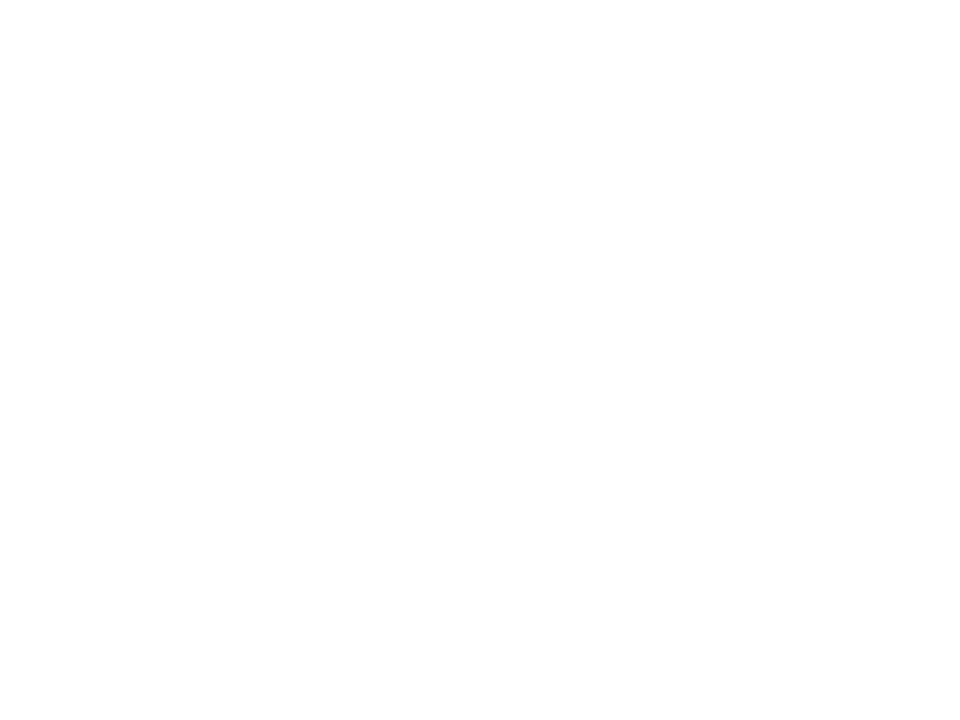

In [30]:
# I was too lazy to interpolate my answers, so here's an animated graph to make up for it

%matplotlib notebook
import matplotlib.animation as animation
from IPython import display

fig, (axA, axB) = pyp.subplots(2, tight_layout= True, sharex = True, sharey= True)
# fig, axA = pyp.subplots()

RplotA = axA.plot(HighwayA.X, RAH.loc[0,:])[0]
titleA = axA.set_title(f"Case A:\nCar Density t = 0.0")
RplotB = axB.plot(HighwayB.X, RBH.loc[0,:])[0]
titleB = axB.set_title(f"Case B:\nCar Density t = 0.0")
axB.set_xlabel("Distance [km]")
axA.set_ylabel("Density [cars/ km]")
axB.set_ylabel("Density [cars/ km]")

def animate(i):
    RA = RAH.iloc[i,:]
    RB = RBH.iloc[i,:]

    RplotA.set_data((HighwayA.X, RA))
    titleA.set_text(f"Case A:\nCar Density t = {RAH.index[i]:.3f}")
    RplotB.set_data((HighwayA.X, RB))
    titleB.set_text(f"Case B:\nCar Density t = {RBH.index[i]:.3f}")

    return RplotA, RplotB, titleA, titleB
#     return RplotA, titleA


ani = animation.FuncAnimation(fig, animate, frames=len(VAH.index), interval = 50)
video = ani.to_html5_video()
pyp.close()
html = display.HTML(video)
display.display(html)


## Conservation and non-conservation forms

---

The traffic flow is modeled by the following equation

$$
\begin{equation}
    \frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0
\end{equation}
$$

where $\rho$ is the density and $F$ is the flux of density given by

$$
\begin{equation*}
    F = F \left( \rho \right) = \rho V \left( \rho \right) = \rho V_\text{max} \left( 1 - \frac{\rho}{\rho_\text{max}} \right)
\end{equation*}
$$

The equation above is called the **conservation form** of the traffic-flow equation.

Alternatively, we could also write another equation by deriving the flux with respect to $x$:

$$
\begin{eqnarray*}
    \frac{\partial \rho}{\partial t} &=& -\frac{\partial F}{\partial x} \\
    &=& -\frac{\partial F}{\partial \rho} \frac{\partial \rho}{\partial x} \\
    &=& - V_\text{max} \left( 1 - 2 \frac{\rho}{\rho_\text{max}} \right) \frac{\partial \rho}{\partial x}
\end{eqnarray*}
$$

i.e.,

$$
\begin{equation}
    \frac{\partial \rho}{\partial t} + V_\text{max} \left( 1 - 2 \frac{\rho}{\rho_\text{max}} \right) \frac{\partial \rho}{\partial x} = 0
\end{equation}
$$

The equation above is call the **non-conservation form** of the traffic-flow equation.

Although the two equations are mathematically identical, their respective discrete version is different and will not lead to the same numerical solution.

Suppose, we want to advance the solution in time using a first-order Euler's method while computing the space derivative using a backward-difference technique.

The discrete version of the equation in conservation form is

$$
\begin{equation}
    \frac{\rho_i^{n + 1} - \rho_i^n}{\Delta t} + \frac{F_i^n - F_{i-1}^n}{\Delta x} = 0
\end{equation}
$$

which leads to

$$
\begin{equation}
    \frac{\rho_i^{n + 1} - \rho_i^n}{\Delta t} + \frac{\rho_i^n V_\text{max} \left( 1 - \frac{\rho_i^n}{\rho_\text{max}} \right) - \rho_{i - 1}^n V_\text{max} \left( 1 - \frac{\rho_{i - 1}^n}{\rho_\text{max}} \right)}{\Delta x} = 0
\end{equation}
$$

The discrete version of the equation in non-conservation form is

$$
\begin{equation}
    \frac{\rho_i^{n + 1} - \rho_i^n}{\Delta t} + V_\text{max} \left( 1 - 2 \frac{\rho_i^n}{\rho_\text{max}} \right) \frac{\rho_i^n - \rho_{i - 1}^n}{\Delta x} = 0
\end{equation}
$$

You can see that the two discrete equations are different, and thus will not lead to the same numerical solution.

For the second assignment of this class, you should discretize the traffic-flow equation in its conservation form.